## IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

import os
import platform
import sys

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.models import Model
from deepface.basemodels import VGGFace

from src.functions_for_data_viz import collect_file_paths
from src.functions_for_DL_model import image_preprocessing, scratch_model, plot_history
from src.constants import SIZE, batch_size

In [2]:
# SET UP IMAGES PATH AND TRAIN, TEST, VAL PATHS

# Path to images folder
images_path = 'images/'

# Paths to train, val, and test folders
train_folder = images_path + 'train'
val_folder = images_path + 'val'
test_folder = images_path + 'test'

# Lists to store file paths using a function in src for: train, val and test
train_NORMAL_paths = collect_file_paths(os.path.join(train_folder, 'NORMAL'))
train_PNEUMONIA_paths = collect_file_paths(os.path.join(train_folder, 'PNEUMONIA'))

val_NORMAL_paths = collect_file_paths(os.path.join(val_folder, 'NORMAL'))
val_PNEUMONIA_paths = collect_file_paths(os.path.join(val_folder, 'PNEUMONIA'))

test_NORMAL_paths = collect_file_paths(os.path.join(test_folder, 'NORMAL'))
test_PNEUMONIA_paths = collect_file_paths(os.path.join(test_folder, 'PNEUMONIA'))

# Max numbers of images
print("Number of files in train_NORMAL:", len(train_NORMAL_paths))
print("Number of files in train_PNEUMONIA:", len(train_PNEUMONIA_paths))
print("========================================")
print("Number of files in val_NORMAL:", len(val_NORMAL_paths))
print("Number of files in val_PNEUMONIA:", len(val_PNEUMONIA_paths))
print("========================================")
print("Number of files in test_NORMAL:", len(test_NORMAL_paths))
print("Number of files in test_PNEUMONIA:", len(test_PNEUMONIA_paths))


Number of files in train_NORMAL: 1341
Number of files in train_PNEUMONIA: 3875
Number of files in val_NORMAL: 8
Number of files in val_PNEUMONIA: 8
Number of files in test_NORMAL: 234
Number of files in test_PNEUMONIA: 390


## IMAGE PREPROCESSING

In [3]:
# Data preprocessing steps for each image folders: train, val, test

# Path to images folder
images_path = 'images/'

# Paths to train, val, and test folders
train_folder = images_path + 'train'
val_folder = images_path + 'val'
test_folder = images_path + 'test'

print("Training:")
train_generator = image_preprocessing(train_folder)

print("Validation:")
val_generator = image_preprocessing(val_folder)

print("Test:")
test_generator = image_preprocessing(test_folder)

Training:
Found 5216 images belonging to 2 classes.
Validation:
Found 16 images belonging to 2 classes.
Test:
Found 624 images belonging to 2 classes.


In [4]:
# Iterate over the generator
for batch_index, (batch_of_images, batch_of_labels) in enumerate(val_generator):
    # Print batch index
    print("Batch", batch_index)
    
    # Print batch shape and labels
    print("Batch shape:", batch_of_images.shape)
    print("Batch labels:", batch_of_labels)
    
    # Optionally, you can print or visualize images and labels within the batch
    # for i in range(batch_of_images.shape[0]):  # Iterate over images in the batch
    #     plt.imshow(batch_of_images[i])
    #     plt.title("Label: " + str(batch_of_labels[i]))
    #     plt.show()
    
    if batch_index == 3:
        break


Batch 0
Batch shape: (1, 224, 224, 3)
Batch labels: [0.]
Batch 1
Batch shape: (1, 224, 224, 3)
Batch labels: [0.]
Batch 2
Batch shape: (1, 224, 224, 3)
Batch labels: [0.]
Batch 3
Batch shape: (1, 224, 224, 3)
Batch labels: [0.]


## DL MODEL FROM SCRATCH

In [6]:
# Model definition

model = scratch_model()

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

In [4]:
# Model definition

model = scratch_model()

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

2024-05-30 10:54:32.847950: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-30 10:54:32.847988: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-30 10:54:32.847992: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-30 10:54:32.848261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-30 10:54:32.848705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [4]:
# Check if GPU is available

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-12.5-arm64-arm-64bit
Tensor Flow Version: 2.15.1
Keras Version: 2.15.0

Python 3.11.9 (main, Apr  2 2024, 16:11:47) [Clang 14.0.0 (clang-1400.0.29.202)]
GPU is available


In [5]:
# Define weights to handle class imblance

weight_0 = len(train_PNEUMONIA_paths) / (len(train_NORMAL_paths) + len(train_PNEUMONIA_paths))
weight_1 = len(train_NORMAL_paths) / (len(train_NORMAL_paths) + len(train_PNEUMONIA_paths))

imbalanced_weight = {0: weight_0, 1: weight_1}

print(f"Weight for label 0: {weight_0:.2f}")
print(f"Weight for label 1: {weight_1:.2f}")

Weight for label 0: 0.74
Weight for label 1: 0.26


In [10]:
# Train the model with GPU acceleration if available

val_steps_per_epoch = val_generator.n // val_generator.batch_size
train_steps_per_epoch = train_generator.n // train_generator.batch_size

if gpu:
    with tf.device('/device:GPU:0'):
        print('Training on GPU')
        history = model.fit(train_generator,
                    steps_per_epoch = train_steps_per_epoch,
                    epochs = 10,
                    validation_data = val_generator,
                    validation_steps = val_steps_per_epoch,
                    class_weight=imbalanced_weight)
else:
    print("Training on CPU")
    history = model.fit(train_generator,
                    steps_per_epoch = train_steps_per_epoch,
                    epochs = 10,
                    validation_data = val_generator,
                    validation_steps = val_steps_per_epoch,
                    class_weight=imbalanced_weight)

Training on GPU
Epoch 1/10


2024-05-30 16:56:22.038063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


326/326 [==============================] - 43s 130ms/step - loss: 1.1356 - accuracy: 0.9162 - val_loss: 65.5055 - val_accuracy: 0.5000
Epoch 2/10
326/326 [==============================] - 43s 131ms/step - loss: 1.0956 - accuracy: 0.9216 - val_loss: 1.6138 - val_accuracy: 0.9375
Epoch 3/10
326/326 [==============================] - 43s 131ms/step - loss: 1.0053 - accuracy: 0.9402 - val_loss: 17.0564 - val_accuracy: 0.5000
Epoch 4/10
326/326 [==============================] - 45s 138ms/step - loss: 1.3284 - accuracy: 0.9383 - val_loss: 72.1061 - val_accuracy: 0.5625
Epoch 5/10
326/326 [==============================] - 50s 153ms/step - loss: 1.0166 - accuracy: 0.9517 - val_loss: 5.9726 - val_accuracy: 0.8125
Epoch 6/10
326/326 [==============================] - 50s 154ms/step - loss: 0.7408 - accuracy: 0.9649 - val_loss: 94.1339 - val_accuracy: 0.5000
Epoch 7/10
326/326 [==============================] - 53s 163ms/step - loss: 0.8157 - accuracy: 0.9580 - val_loss: 54.9050 - val_accuracy

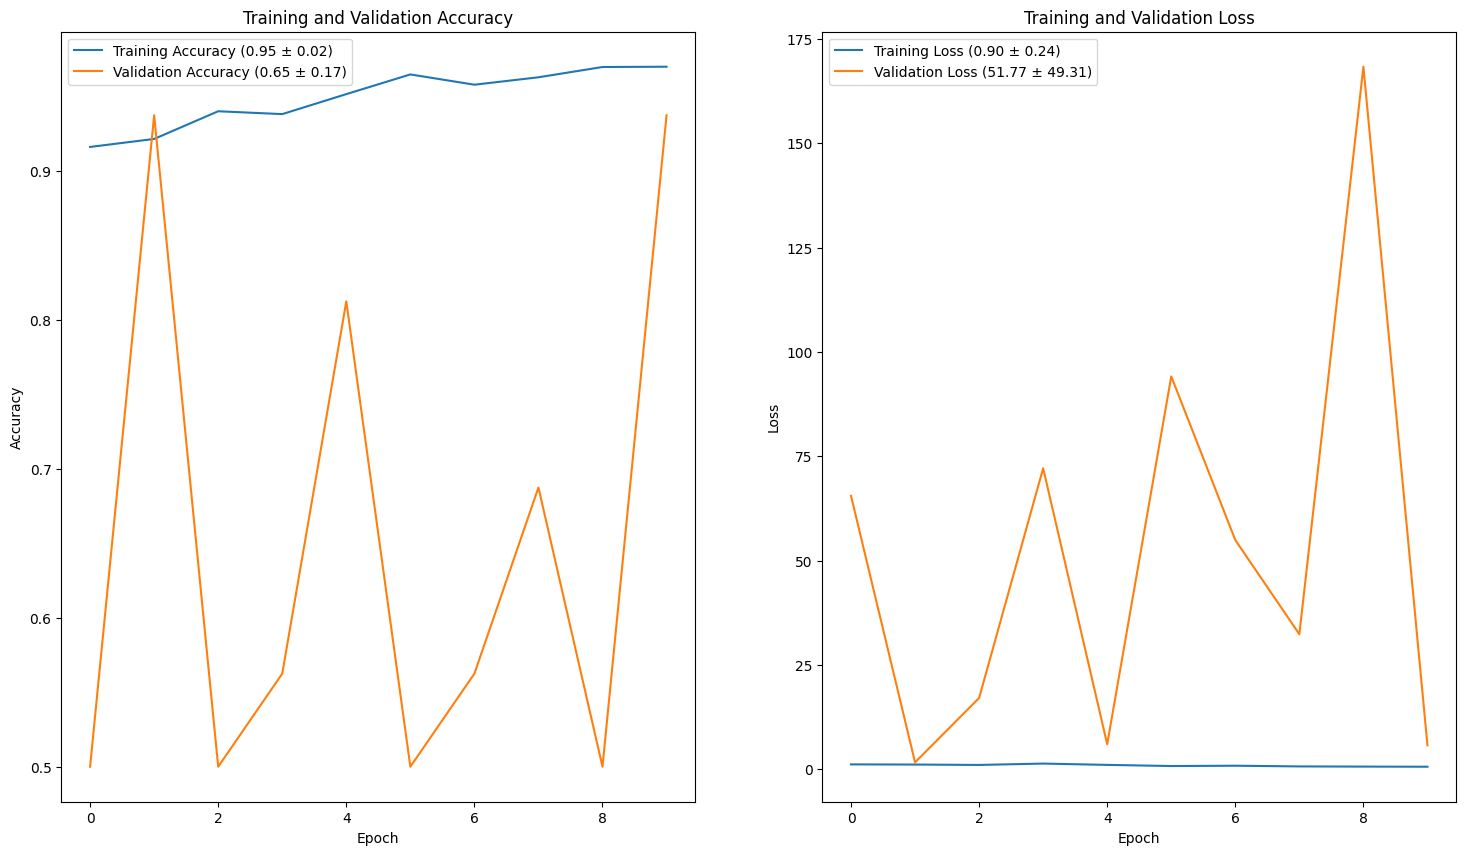

In [12]:
# VISUALIZE EVALUATION RESULTS

plot_history(history)

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f'Test accuracy: {test_acc}')

624/624 [==============================] - 6s 8ms/step - loss: 16.8889 - accuracy: 0.8157
Test accuracy: 0.8157051205635071


In [14]:
# Evaluate classification metrics for test predictions

predictions = model.predict(test_generator)

pd.DataFrame(classification_report(test_generator.classes, predictions > 0.5, output_dict=True))

624/624 [==============================] - 5s 7ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.894040,0.790698,0.815705,0.842369,0.829451
recall,0.576923,0.958974,0.815705,0.767949,0.815705
f1-score,0.701299,0.866744,0.815705,0.784021,0.804702
support,234.000000,390.000000,0.815705,624.000000,624.000000


## TRANSFER LEARNING

In [6]:
# Define and create (if not exist) the directory for saving model weights
weights_dir = os.path.expanduser("~/.deepface/weights")
os.makedirs(weights_dir, exist_ok=True)

# Load the VGG-Face model from DeepFace
vgg_model = VGGFace.load_model()

# Freeze the layers of VGG-Face model
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = vgg_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=vgg_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_input (Inpu  [(None, 224, 224, 3)]     0         
 tLayer)                                                         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                           

In [7]:
# Train the model with GPU acceleration if available

val_steps_per_epoch = val_generator.n // val_generator.batch_size
train_steps_per_epoch = train_generator.n // train_generator.batch_size

if gpu:
    with tf.device('/device:GPU:0'):
        print('Training on GPU')
        history = model.fit(train_generator,
                    steps_per_epoch = train_steps_per_epoch,
                    epochs = 10,
                    validation_data = val_generator,
                    validation_steps = val_steps_per_epoch,
                    class_weight=imbalanced_weight)
else:
    print("Training on CPU")
    history = model.fit(train_generator,
                    steps_per_epoch = train_steps_per_epoch,
                    epochs = 10,
                    validation_data = val_generator,
                    validation_steps = val_steps_per_epoch,
                    class_weight=imbalanced_weight)
    
# Save the model
model.save('models/pneumonia_detection_model_VGGFace.h5')

Training on GPU
Epoch 1/10
326/326 [==============================] - 131s 397ms/step - loss: 0.1063 - accuracy: 0.9003 - val_loss: 0.6334 - val_accuracy: 0.6250
Epoch 2/10
326/326 [==============================] - 145s 446ms/step - loss: 0.0656 - accuracy: 0.9298 - val_loss: 0.5978 - val_accuracy: 0.7500
Epoch 3/10
326/326 [==============================] - 149s 458ms/step - loss: 0.0593 - accuracy: 0.9360 - val_loss: 0.5063 - val_accuracy: 0.7500
Epoch 4/10
326/326 [==============================] - 230s 703ms/step - loss: 0.0542 - accuracy: 0.9417 - val_loss: 0.4705 - val_accuracy: 0.7500
Epoch 5/10
326/326 [==============================] - 235s 718ms/step - loss: 0.0525 - accuracy: 0.9444 - val_loss: 0.4639 - val_accuracy: 0.7500
Epoch 6/10
326/326 [==============================] - 247s 757ms/step - loss: 0.0487 - accuracy: 0.9469 - val_loss: 0.4246 - val_accuracy: 0.7500
Epoch 7/10
326/326 [==============================] - 259s 794ms/step - loss: 0.0488 - accuracy: 0.9492 - va

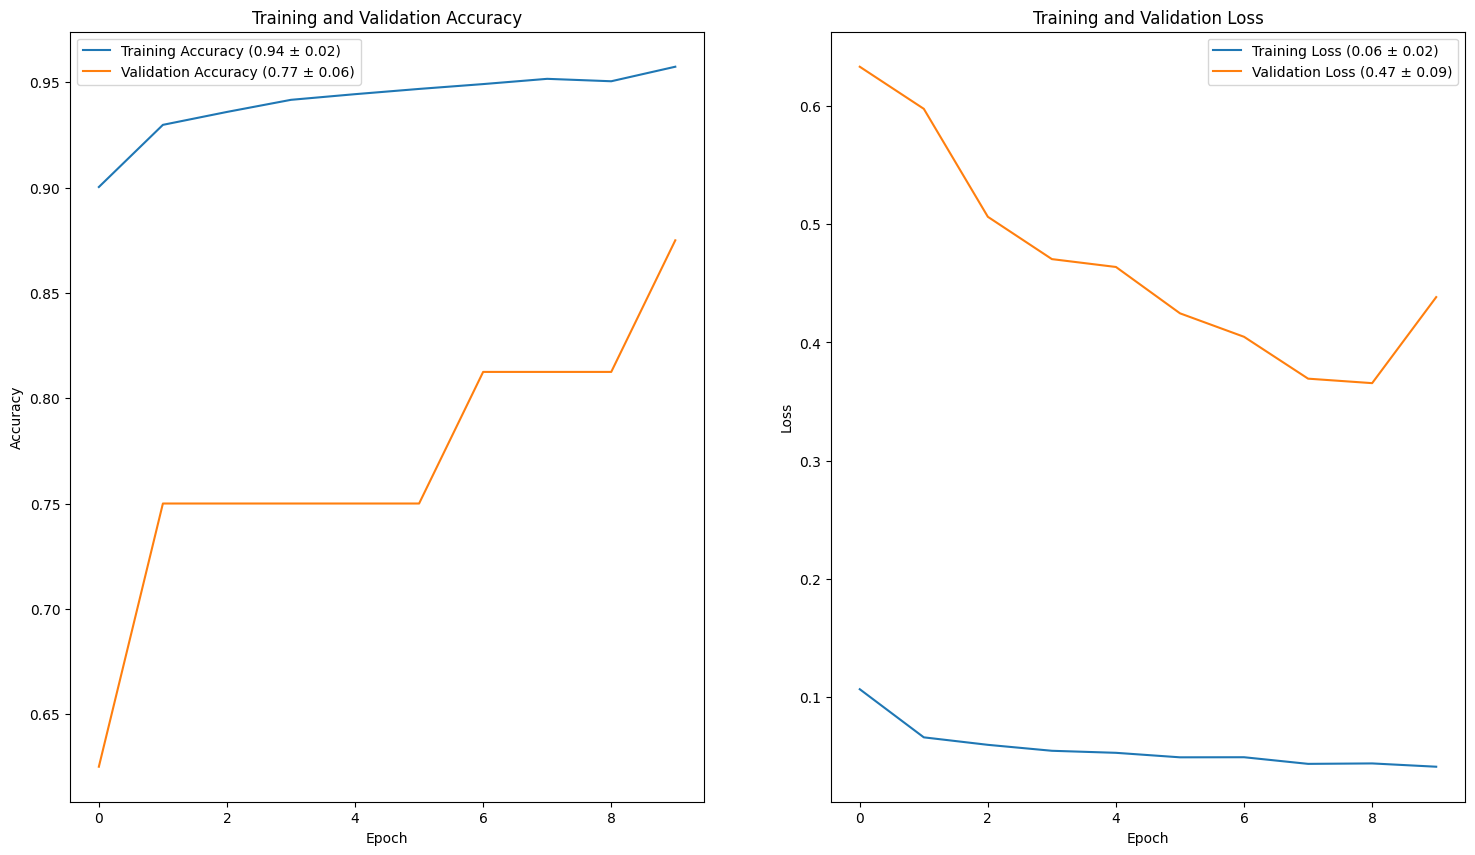

In [8]:
# VISUALIZE EVALUATION RESULTS

plot_history(history)

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f'Test accuracy: {test_acc}')

624/624 [==============================] - 19s 29ms/step - loss: 0.2875 - accuracy: 0.8766
Test accuracy: 0.8766025900840759


In [10]:
# Evaluate classification metrics for test predictions

predictions = model.predict(test_generator)

pd.DataFrame(classification_report(test_generator.classes, predictions > 0.5, output_dict=True))

624/624 [==============================] - 18s 28ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.812749,0.919571,0.876603,0.866160,0.879513
recall,0.871795,0.879487,0.876603,0.875641,0.876603
f1-score,0.841237,0.899083,0.876603,0.870160,0.877391
support,234.000000,390.000000,0.876603,624.000000,624.000000
